# <center> Дипломный проект <br> Анализ тональности отзывов <br>

## <center> Соревнование по сентимент-анализу (версия без обучающих данных)

К компании пришел заказчик, которому нужно решение задачи анализа тональности отзывов на товары. Заказчик хочет, чтобы мы оценили возможное качество работы такого алгоритма на небольшой тестовой выборке. При этом больше никаких данных не предоставляется. Требуется, чтобы качество работы вашего алгоритма (по accuracy) было строго больше 85%.

Оценка качества в этом задании реализована через контест на Kaggle Inclass:

https://inclass.kaggle.com/c/product-reviews-sentiment-analysis

Нам предстоит посмотреть на предоставленные заказчиком отзывы, собрать похожие отзывы в качестве обучающей выборки, и поэкспериментировать с постановкой задачи (разметкой вашей выборки на позитивные и негативные примеры) так, чтобы результат на примерах заказчика был по возможности получше.

### Загрузка модулей 

In [3]:
import requests
import bs4
from multiprocessing import Pool
import codecs
from functools import reduce
import time
import random

## Анализ тестовых данных

В наличие имеется всего лишь тестовая выборка в 100 примеров. Необходимо понять к какой тематике относятся эти отзывы.

In [130]:
with open('data/test.csv', 'r') as f:
    test_data_raw = f.read()
parser = bs4.BeautifulSoup(test_data_raw, 'lxml')
test_data = [x.text for x in parser.findAll('review')]

Посмотрим на данные:

In [3]:
for x in test_data:
    print(x + '\n')

Ужасно слабый аккумулятор, это основной минус этого аппарата, разряжается буквально за пару часов при включенном wifi и на макс подсветке, например если играть или смотреть видео, следовательно использовать можно только если есть постоянная возможность подзарядиться. Качества звука через динамик далеко не на высоте.Наблюдаются незначительные тормоза в некоторых приложениях и вообще в меню. Очень мало встроенной памяти, а приложения устанавливаются именно туда, с этим связанны неудобства - нужно постоянно переносить их на карту памяти.
Несколько неудобно что нету отдельной кнопки для фото. Подумываю купить батарею большей емкость мб что нибудь измениться.


т.е.  вы можете видеть всю ветку беседы с конкретным человеком , а не искать в куче входящих смс с нужной информацией.
работает чисто без галюнов,падал,шврялся,купался,используется как тел и плеер,в метро поездов не слышно уши юзаю сенхайзер 300 и 500,mp3 звонок чистый без сипов.Экран  не горилла глас , но на солнце сохраняет читаемо

Как видно, тематика связана отзывами на смартфоны.

## Парсинг обучающей выборки

Парсить будем Яндекс.Маркет раздел смартфоны.

Отзывам соответствует числовая оценка от 1 до 5, поэтому сначала мы соберем все данные, а потом разделим на положительные и отрицательные отзывы.

### Список телефон

In [4]:
url_list = []
for page in range(1,6):
    req = requests.get(f'https://market.yandex.ru/catalog/54726/list?hid=91491&onstock=1&local-offers-first=0&how=opinions&viewtype=list&page={page}')
    parser = bs4.BeautifulSoup(req.text, 'lxml')
    list_class = parser.findAll(attrs={'class':'link n-link_theme_blue'})
    for x in list_class:
        raw_url = x.get('href')
        url ='https://market.yandex.ru' + raw_url[:raw_url.find('?')] + '/reviews'
        url_list.append(url)
print('\n'.join(url_list))

https://market.yandex.ru/product--smartfon-xiaomi-redmi-4-prime/1713398799/reviews
https://market.yandex.ru/product--smartfon-apple-iphone-5s-16gb/10495456/reviews
https://market.yandex.ru/product--smartfon-xiaomi-redmi-4x-32gb/1720465387/reviews
https://market.yandex.ru/product--smartfon-samsung-galaxy-s7-32gb/13485515/reviews
https://market.yandex.ru/product--smartfon-samsung-galaxy-a5-2016-sm-a510f/13188751/reviews
https://market.yandex.ru/product--smartfon-samsung-galaxy-j1-2016-sm-j120f-ds/13340782/reviews
https://market.yandex.ru/product--smartfon-samsung-galaxy-a5-2017-sm-a520f-ds/1716316475/reviews
https://market.yandex.ru/product--smartfon-samsung-galaxy-s7-edge-32gb/13485518/reviews
https://market.yandex.ru/product--smartfon-sony-xperia-z3-d6603/11028534/reviews
https://market.yandex.ru/product--smartfon-samsung-galaxy-s8/1722193751/reviews
https://market.yandex.ru/product--smartfon-sony-xperia-j/8440056/reviews
https://market.yandex.ru/product--smartfon-xiaomi-redmi-note-4x-

In [5]:
print(f'Будем парсить отзывы для {len(url_list)} моделей телефонов')

Будем парсить отзывы для 186 моделей телефонов


### Парсинг отзывов

In [159]:
def parse_model(site):
    print(site[43:][:-8])
    reviews = []
    grade_values = [1,2,4,5]
    for grade in grade_values:
        time.sleep(random.randint(3,7))
        url = site + f'?track=rev_mc_marked&grade_value={grade}'
        req = requests.get(url)
        parser = bs4.BeautifulSoup(req.text, 'lxml')
        list_reviews = parser.findAll('div', attrs={'class':'n-product-review-item i-bem n-product-review-item_collapsed_yes'})
        reviews.extend([(parse_review(review), grade) for review in list_reviews])
    return reviews

In [160]:
def parse_review(data_review):
    raw_review = data_review.findAll('dd', attrs={'class':'n-product-review-item__text'})
    raw_text = [x.text for x in raw_review]
    text = '\n'.join(raw_text)
    return text

In [163]:
%%time
train_data = []
label = []

p = Pool(10)
if __name__ == '__main__':    
    map_results = p.map(parse_model, url_list)
    reduce_results = reduce(lambda x,y: x + y, map_results)
    
    for x,y in reduce_results:
        train_data.append(x)
        label.append(y)
        
    print(f'Количество отзывов и оценок - {len(train_data)},{len(label)}')
    
    with codecs.open('data/parsing_data_new.txt', 'w', 'utf-8') as output_file:
        print('\n-----\n'.join(train_data), file=output_file)
    with codecs.open('data/parsing_label_new.txt', 'w', 'utf-8') as output_file:
        print('\n'.join([str(x) for x in label]), file=output_file)

xiaomi-redmi-4-prime/1713398799
xiaomi-redmi-note-4x-4-64gb/1727365510
xiaomi-redmi-5-plus-4-64gb/1831859946
samsung-galaxy-a5-2017-sm-a520f-ds/1716316475
lenovo-p780-8gb/10546687
lg-x-power-k220ds/14020941
apple-iphone-6-16gb/11031621
samsung-galaxy-s8-64gb/1722193758
asus-zenfone-2-laser-ze550kl-16gb/12595940
samsung-galaxy-s5-mini-sm-g800f/10949376
xiaomi-redmi-note-5-4-64gb/1968186709
xiaomi-redmi-4x-16gb/1720328396
samsung-galaxy-a3-2017-sm-a320f-ds/1716271099
apple-iphone-5s-16gb/10495456
samsung-galaxy-s7-edge-32gb/13485518
huawei-p9-lite-2-16gb/13792113
apple-iphone-7-32gb/14206636
samsung-galaxy-star-plus-gt-s7262/10566605
samsung-galaxy-j3-2016-sm-j320f-ds/13579073
bq-bqs-5020-strike/13922107
sony-xperia-xa/13486418
leeco-le-2-32gb/13925383
microsoft-lumia-640-3g-dual-sim/12260784
honor-10-4-64gb/43052347
xiaomi-redmi-4x-32gb/1720465387
sony-xperia-z3-d6603/11028534
honor-7-16gb/12670591
blackview-bv6000/13837623
honor-8-4-32gb/14162579
lg-g3-s-d724/10967066
blackberry-z30/10

Мы получили 6028 отзывов)

# Обучение модели

Обучающую выборку мы получили, приступим к построению модели.

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
with codecs.open('data/parsing_data_new.txt', 'r', 'utf-8') as file:
    train_data = file.read().split('\n-----\n')[:-1]
with codecs.open('data/parsing_label_new.txt', 'r', 'utf-8') as file:
    label = file.read().split('\n')[:-1]
    label = [int(x) for x in label]

In [5]:
print(train_data[0])

Внешний вид.
Микрофон. Гарантия на товар.
Сразу после покупки обнаружился серьезный дефект: меня слышно очень плохо, звук периодически становится очень тихим или пропадает совсем. Вероятно, проблема в микрофоне.
Собеседнику приходится постоянно переспрашивать, или перезванивать на другой телефон. 
По всем прочим параметрам претензий к устройству нет, но со своей основной функцией -- голосового общения -- он не справляется, использовать его именно как телефон невозможно.
Вдобавок телефон (совершенно новый, с чеком и гарантийным талоном) фактически оказался без гарантии: сервисный центр, с которым договор у xiaomi, и чей гарантийный талон прилагался (это оказался печально известный "чини таун", погуглите отзывы) только имитирует ремонт.
Я дважды отвозил им устройство, оба раза мне его возвращали обратно с тем же самым дефектом. 
(в первый раз вообще "починили" за 2 часа, у меня есть сомнения, что телефон в прнципе открывали:)) )
Придется чинить за деньги в другом сервисе.
В общем, если с

In [6]:
data = pd.DataFrame(columns=['text','label'])
data['text'] = train_data
data['label'] = label

Разделим отзывы на положительные и отрицательные:
- к положительным отнесем отзывы с оценками 4 и 5
- к отрицательным - 1, 2

Отзывы с оценкой 3 считаем нейтральными и исключаем из выборки.

In [7]:
data = data[data.label != 3]

In [8]:
data['label'] = data.label.apply(lambda x: 0 if x == 1 or x == 2 else 1)

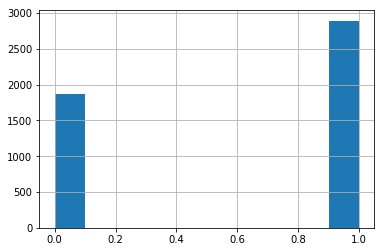

In [9]:
data.label.hist();

Распределение на классы получилось неравномерным, учтем это в дальнейшем.

In [10]:
X = data.text
y = data.label

## Выбор модели

In [11]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
import nltk
import pickle

In [12]:
def testing_model(model, vectorizer, train_data, label):
    pipepline = make_pipeline(vectorizer, model)
    score = cross_val_score(pipepline, train_data, label, scoring='accuracy', cv=5, n_jobs=-1)
    return score.mean()

In [13]:
def answer_to_kaggle(predict, file_name):
    neg_pos = []
    for y in predict:
        if y == 0:
            neg_pos.append('neg')
        else:
            neg_pos.append('pos')
    answer = pd.DataFrame(neg_pos, columns=['y'])
    answer.to_csv(file_name,index_label='id')

In [14]:
pipe = Pipeline([('vectorizer', CountVectorizer()), ('classifier', LogisticRegression())])

In [24]:
param_grid = [
    {'classifier': [LogisticRegression(), LinearSVC()], 
    'vectorizer': [CountVectorizer(), TfidfVectorizer()],
    'classifier__class_weight': ['balanced'],
    'vectorizer__ngram_range': [(1,1), (1,2)]
    }]

In [25]:
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

In [26]:
%%time
grid.fit(X, y)
print(grid.best_params_)

{'classifier': LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 'classifier__class_weight': 'balanced', 'vectorizer': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 'vectorizer__ngram_range': (1, 2)}
CPU times: user 5.74 s, sys: 366 ms, total: 6.1 s
Wall time: 1min 16s


In [27]:
grid.best_score_

0.8425362166701659

In [28]:
best_model = grid.best_estimator_

In [29]:
grid_C = {'classifier__C': np.linspace(1e-4, 5, 10)}
grid_tune = GridSearchCV(best_model, grid_C, cv=5, n_jobs=-1)
grid_tune.fit(X, y)
print(grid_tune.best_params_)

{'classifier__C': 0.5556444444444445}


In [30]:
grid_tune.best_score_

0.8427461683812723

Сохраним обученную модель:

In [34]:
with open('data/pipeline.pkl', 'wb') as f:
    pickle.dump(grid_tune.best_estimator_, f)

Вычислим прогноз на тестовой выборке и отправим на kaggle:

In [128]:
predict = grid_tune.predict(test_data)
answer_to_kaggle(predict, 'data/predict.csv')

In [131]:
for x,y in zip(test_data, predict):
    print(x)
    print(y)
    print('\n')

Ужасно слабый аккумулятор, это основной минус этого аппарата, разряжается буквально за пару часов при включенном wifi и на макс подсветке, например если играть или смотреть видео, следовательно использовать можно только если есть постоянная возможность подзарядиться. Качества звука через динамик далеко не на высоте.Наблюдаются незначительные тормоза в некоторых приложениях и вообще в меню. Очень мало встроенной памяти, а приложения устанавливаются именно туда, с этим связанны неудобства - нужно постоянно переносить их на карту памяти.
Несколько неудобно что нету отдельной кнопки для фото. Подумываю купить батарею большей емкость мб что нибудь измениться.

0


ценанадежность-неубиваемостьдолго держит батарею 4 дня стабильно как телефон, 3-4 как плеер если 
постоянно долбиться в уши и звонить по паре часо на дню, игры и, конечно,  смс , в месяц около 200 шт набирается.
 Максимальное время работы 5 дней в щадящем режиме.2 simqwerty рулит -после нее набор смс на обычных сенсорниках и кнопо

На тестовой выборке получили качество работы 0.9, что больше требуемых 85%.

Спасибо за просмотр!